# Initialization

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install lightning

In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

class ImageTextDataset(Dataset):
    def __init__(self, image_paths, texts, transform=None):
        self.image_paths = image_paths
        self.texts = texts
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)

        text = self.texts[idx]
        return image, text

In [4]:
import torch
import torch.nn as nn
from transformers import CLIPProcessor, CLIPModel
import lightning as pl

class CLIPLightningModule(pl.LightningModule):
    def __init__(self, model_name="openai/clip-vit-base-patch32", learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # Load the pretrained CLIP model
        self.model = CLIPModel.from_pretrained(model_name)
        self.processor = CLIPProcessor.from_pretrained(model_name)

        # Loss function
        self.loss_fn = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate

    def forward(self, images, texts):
        # Tokenize text and preprocess images
        # The key change is here, where we truncate sequences to the model's max length
        inputs = self.processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True, max_length=77).to(self.device)
        outputs = self.model(**inputs)
        return outputs

    def training_step(self, batch, batch_idx):
        images, texts = batch

        # Get CLIP outputs
        # The key change is here, where we truncate sequences to the model's max length
        inputs = self.processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True, max_length=77, do_rescale=False).to(self.device)
        outputs = self.model(**inputs)

        # CLIP returns logits_per_image and logits_per_text
        logits_per_image = outputs.logits_per_image  # [batch_size, batch_size]
        logits_per_text = outputs.logits_per_text    # [batch_size, batch_size]

        # Compute loss
        labels = torch.arange(logits_per_image.size(0)).to(self.device)
        image_loss = self.loss_fn(logits_per_image, labels)
        text_loss = self.loss_fn(logits_per_text, labels)
        loss = (image_loss + text_loss) / 2

        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

    def save_model(self, output_dir="clip_model"):
        """
        Save the trained model and processor to the specified directory.
        """
        output_dir = output_dir.rstrip("/")
        self.model.save_pretrained(output_dir)  # Save the model
        self.processor.save_pretrained(output_dir)  # Save the processor
        print(f"Model and processor saved to {output_dir}")

c:\Users\Pongo\.conda\envs\kohya_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# prompt: list the filenames of non txt file in this folder and it subfolders /content/drive/MyDrive/[04] Penelitian/23G2/BIMA/dataset and save it as a list

import os

def find_dataset_path(root_dir):
    imgs = []
    prompts = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if not filename.endswith(".txt"):
                imgs.append(os.path.join(dirpath, filename))
                prompts.append(os.path.join(dirpath, f"{filename[:-3]}txt"))
    return imgs, prompts

# Training (skip this if don't want to train)

In [6]:
# dataset_dir = "/content/drive/MyDrive/[04] Penelitian/24G2/tongkonan/tongkonan"
dataset_dir = r"C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ideas n Innovation\Project\25-5-6 -- CLIP - SD\Dataset\Train\2_Enhance"
image_paths, texts = find_dataset_path(dataset_dir)

In [7]:
from torchvision import transforms

# Image transformations
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
])

# Example dataset
# image_paths = list_non_txt_files(root_dir)
# texts = ["This is an image of a dog.", "This is an image of a cat."]

dataset = ImageTextDataset(image_paths, texts, transform=image_transforms)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [8]:
from lightning.pytorch import Trainer

# Initialize the model
model = CLIPLightningModule(learning_rate=1e-4)

# Define the trainer
trainer = Trainer(
    max_epochs=50,
    accelerator="gpu",  # Use "gpu" if available, otherwise "cpu"
    devices=1 if torch.cuda.is_available() else None,
)

# Train the model
trainer.fit(model, train_dataloaders=dataloader)
saved_model_dir_path = r"C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ideas n Innovation\Project\25-5-6 -- CLIP - SD\Output\CLIP"
model.save_model(saved_model_dir_path)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Pongo\.conda\envs\kohya_env\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorbo

Epoch 1: 100%|██████████| 27/27 [00:05<00:00,  5.11it/s, v_num=3]

OSError: [Errno 28] No space left on device

# Inference

In [ ]:
model_name = 'Realistic'
dataset_dir = r"C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ideas n Innovation\Project\25-5-6 -- CLIP - SD\Dataset\Train\2_Enhance"
saved_model_dir_path = r"C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ideas n Innovation\Project\25-5-6 -- CLIP - SD\Output\CLIP"
image_paths, texts = find_dataset_path(dataset_dir)

In [ ]:
from transformers import CLIPModel, CLIPProcessor

# Load the saved model and processor
model_path = saved_model_dir_path
model = CLIPModel.from_pretrained(model_path)
processor = CLIPProcessor.from_pretrained(model_path)

In [ ]:
temperature = model.logit_scale.exp().item()
temperature

98.70084381103516

In [ ]:
from transformers import CLIPModel, CLIPProcessor

def compute_clip_score(model, processor, image_path, text):
    image = Image.open(image_path).convert("RGB")
    # image = torch.randint(255, (3,224,224))
    inputs = processor(text=[text], images=[image], return_tensors="pt", padding=True, truncation=True, max_length=77)
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # Similarity score
    return logits_per_image.item()

In [ ]:
# Example usage
# image_path = image_paths[1]
# text = texts[1]
# clip_score = compute_clip_score(model, processor, image_path, text)
# print(f"CLIPScore: {clip_score}")

In [ ]:
import matplotlib.pyplot as plt

# Compute CLIPScores
clip_scores = []
face_vs_attr = []
for image_path, caption in zip(image_paths, texts):
    score = compute_clip_score(model, processor, image_path, caption)
    clip_scores.append(score)
    if 'FACE' in image_path:
        face_vs_attr.append('face')
    else:
        face_vs_attr.append('attr')

# # Visualize CLIPScores
# plt.figure(figsize=(10, 6))
# plt.hist(clip_scores, bins=10, color='skyblue', edgecolor='black')
# plt.title("CLIPScore Distribution")
# plt.xlabel("CLIPScore")
# plt.ylabel("Frequency")
# plt.show()

# # Print scores with their corresponding image and caption
# for img, cap, score in zip(image_paths, texts, clip_scores):
#     print(f"Image: {img}, Caption: {cap}, CLIPScore: {score}")

In [ ]:
# Print scores with their corresponding image and caption
train_results = []
for img, cap, score, fva in zip(image_paths, texts, clip_scores, face_vs_attr):
    train_results += [
        {
            'img' : img,
            'cap' : cap,
            'score' : score,
            'face_vs_attr' : fva
        }
    ]

import pandas as pd

df = pd.DataFrame(train_results)
df.to_excel(f'./Output/inference_result/{model_name}.xlsx', index=False)

c:\Users\Pongo\.conda\envs\kohya_env\lib\site-packages\numpy\lib\_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges
c:\Users\Pongo\.conda\envs\kohya_env\lib\site-packages\scipy\stats\_continuous_distns.py:479: RuntimeWarning: Mean of empty slice.
  loc = data.mean()
c:\Users\Pongo\.conda\envs\kohya_env\lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\Pongo\.conda\envs\kohya_env\lib\site-packages\scipy\stats\_continuous_distns.py:484: RuntimeWarning: Mean of empty slice.
  scale = np.sqrt(((data - loc)**2).mean())


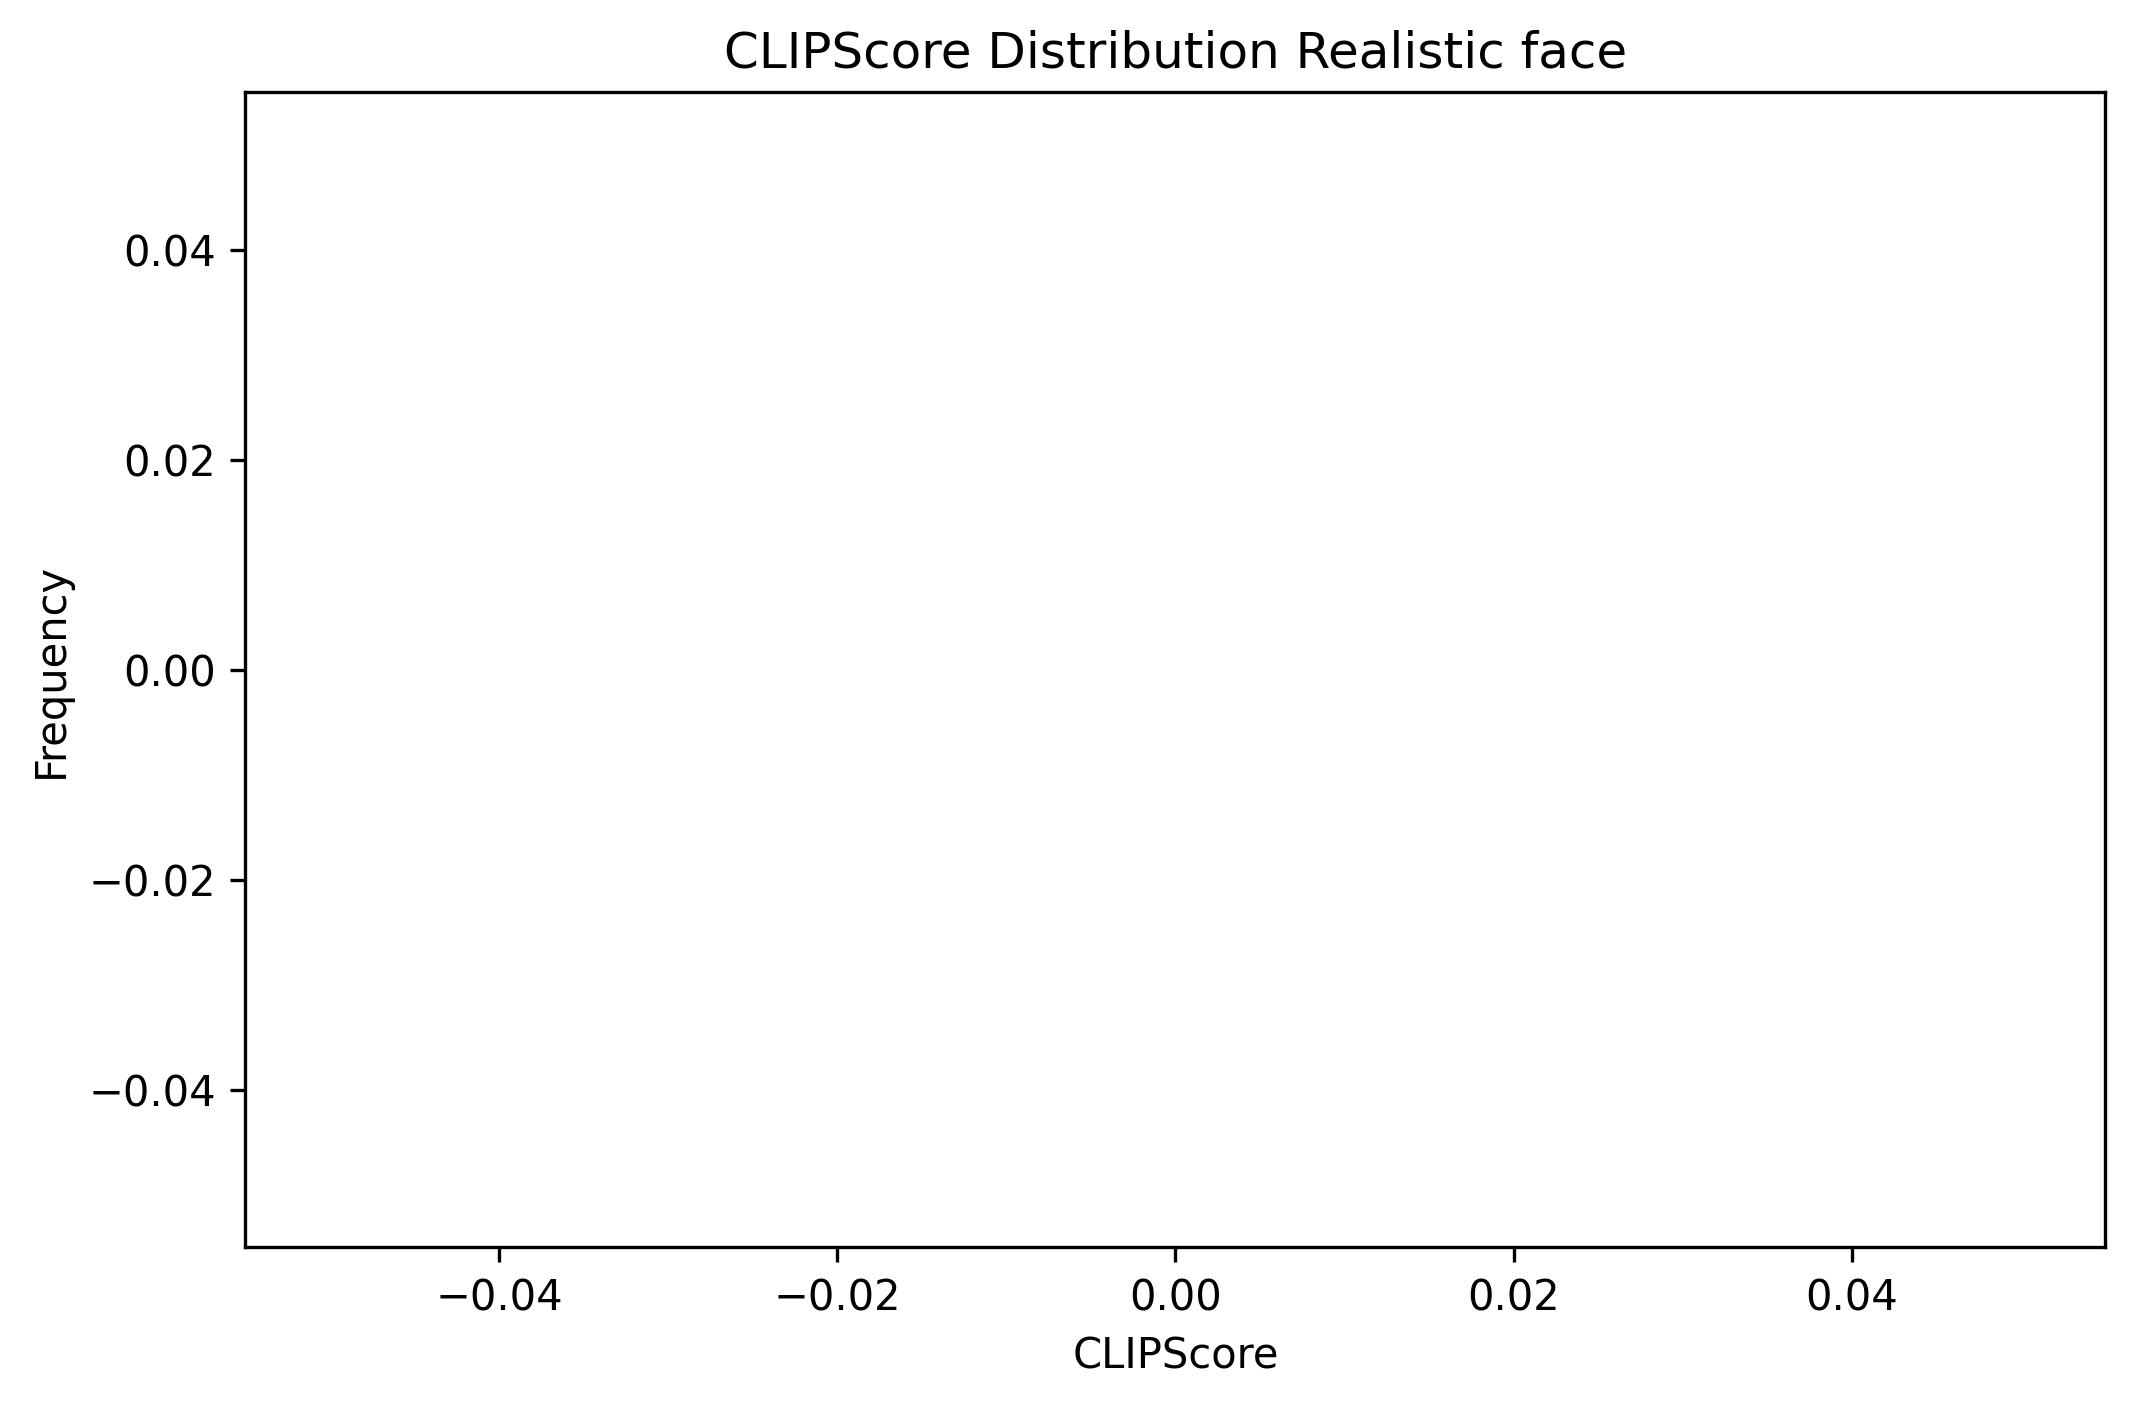

In [ ]:
# Visualize CLIPScores
from scipy.stats import norm
import numpy as np

for fva in ['face','attr']:
    plt.figure(figsize=(8, 5), dpi=300)
    result = plt.hist(df.loc[df['face_vs_attr'] == fva,['score']], bins=10, color='skyblue', density=True, edgecolor='black')
    mu, std = norm.fit(df.loc[df['face_vs_attr'] == fva,['score']])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x, p, 'k--', linewidth=2)
    plt.axvline(mu, color='r', linestyle='dashed', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(mu*0.9, max_ylim*0.9, 'Mean: {:.2f}'.format(mu))
    plt.title(f"CLIPScore Distribution {model_name} {fva}")
    plt.xlabel("CLIPScore")
    plt.ylabel("Frequency")
    plt.savefig(f'./Output/inference_result/{model_name}_{fva}.svg')
    plt.savefig(f'./Output/inference_result/{model_name}_{fva}.png')

In [ ]:
import pandas as pd

df = pd.read_excel(f'./Output/inference_result/{model_name}.xlsx')
df

,img,cap,score,face_vs_attr
0,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,11.759388,attr
1,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,11.760178,attr
2,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,11.751993,attr
3,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,11.754565,attr
4,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,11.766298,attr
5,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,11.775683,attr
6,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,11.770187,attr
7,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,11.773928,attr
8,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,11.775252,attr
9,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,C:\Users\Pongo\OneDrive\Documents\~Cornel\~Ide...,11.774223,attr


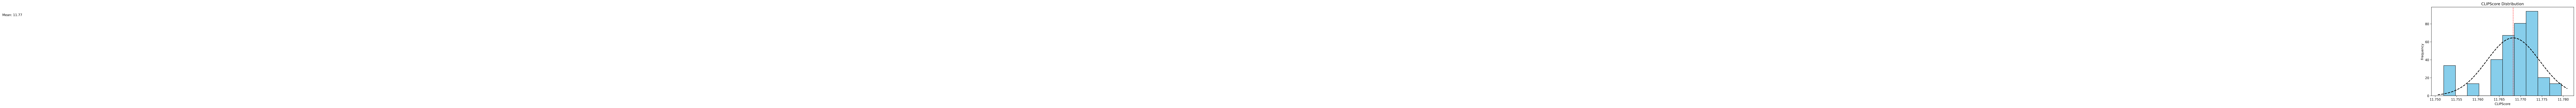

In [ ]:
# Visualize CLIPScores
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5), dpi=300)
result = plt.hist(df['score'], bins=10, color='skyblue', density=True, edgecolor='black')
mu, std = norm.fit(df['score'])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k--', linewidth=2)
plt.axvline(mu, color='r', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(mu*0.95, max_ylim*0.9, 'Mean: {:.2f}'.format(mu))
plt.title(f"CLIPScore Distribution")
plt.xlabel("CLIPScore")
plt.ylabel("Frequency")
plt.savefig(f'./Output/inference_result/training_results.svg')
plt.savefig(f'./Output/inference_result/training_results.png')